# DSGA1007 - Programming for Data Science Lab
Comprehensive example using most of the concepts we have learned so far.

## Objective
The objective of this Lab is to build a toy library to perform hypothesis testing.
The idea is to have in mind the usual criteria that we have used to evaluate the quality of a software product.

These are:

### Correctness
- The program produces the correct output when run using the command

### Exception/Error Handling
- All possible exceptions are handled correctly
- The code catches specific exceptions (e.g. KeyboardInterrupt) rather than using a catchall statement
- Invalid user input is handled correctly (when input is required by the assignment)
- User defined exception(s) are employed for indicating error conditions rather than raising generic exceptions

### Comments
- The main program contains a comment that lists the authors, and describes the overall program behavior
- Comments are used to explain intent and/or warn of consequences where appropriate
- Doc strings are used to describe each function
- Comments are used to document public methods in the class
- There is no commented out code

### Structure
- At least one class is used
- The class is in separate module from main program
- Modules are used to structure the program
- The program is correctly structured as a Python package
- The code is easily understandable (i.e. divided into logical sections, well structured, etc.)
- The code uses meaningful names for variables, functions, and methods, and avoids “Hungarian” notation
- Function/method bodies are kept small

### Testing
- Unit tests are provided with the solution code
- The unit tests pass correctly

## Hypothesis Testing Overview by Example
We will describe the Hypothesis Testing framework using the [Professional Hockey DatabaseData on hockey players, teams, and coaches from 1909 to 2011](https://www.kaggle.com/open-source-sports/professional-hockey-database) as an example to build a test.

The framwork works as follows:
We formulate a Null Hypothesis (H0) and an alternative Hypothesis (H1).
In our case we will test whether the average goals scored in 2011 by players who are born in the first 3 months of the year (Group_A) is higher than the average goals scored in 2011 by players who are born in the rest of the year (Group_B). This test is motivated by [Malcolm Gladwell Outliers](http://nymag.com/arts/books/features/52014/index2.html) example on Canadian Hockey players. If you don't know Malcom Gladwell I sugest looking his [TED Talks](https://www.ted.com/speakers/malcolm_gladwell), it has nothing to do with Python or Hypothesis Testing, but they are cool :)

**H0: mean(Group_A['G']) - mean(Group_B['G']) = 0**

**H1: mean(Group_A['G']) - mean(Group_B['G']) > 0**

Notice that mean(Group_A['G']) - mean(Group_B['G']) is just a single quantity that summarizes the data, we will call this a Test Statistic. We need to establish (by assumption or by estimation) a distribution for this Test Statistic under the Null Hypothesis (If we assume that H0 is true, how would the Test Statistic be distributed). We will assume that the distribution of two sample means is Normal and the calculcation for the parameters will be provided.

The signifficance of a Hypothesis Test (alpha) is the probability of rejecting the null hypothesis when it is true. We can think of it as a threshold for the probability of the Test Statistic for our data. This is established for a certain test beforehand (5% is usually used).

Finally, we need to check if the probability of the Test Statistic value for the data given its distribution (called p-value) is lower than the threshold we established then we can reject the null hypothesis.

## Hypothesis Testing Specification

You are provided with a sample Module (hypothesis_testing.py) in which you have a base structure of Classes attributes and methods. You don't have to stick to it, it is just an example of how you could structure your code.

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from importlib import reload
from stats_lib import hypothesis_testing as ht

# Since I am currently developing the library I need to reload it
reload(ht)

%matplotlib inline

You will need some data to perform the test.
Load the Master.csv and Scoring.csv and join them in a single dataset called **data**.

In [29]:
players = pd.read_csv('data/Master.csv')
scoring = pd.read_csv('data/Scoring.csv')

In [30]:
players.columns

Index(['playerID', 'coachID', 'hofID', 'firstName', 'lastName', 'nameNote',
       'nameGiven', 'nameNick', 'height', 'weight', 'shootCatch', 'legendsID',
       'ihdbID', 'hrefID', 'firstNHL', 'lastNHL', 'firstWHA', 'lastWHA', 'pos',
       'birthYear', 'birthMon', 'birthDay', 'birthCountry', 'birthState',
       'birthCity', 'deathYear', 'deathMon', 'deathDay', 'deathCountry',
       'deathState', 'deathCity'],
      dtype='object')

In [194]:
scoring.columns

Index(['playerID', 'year', 'stint', 'tmID', 'lgID', 'pos', 'GP', 'G', 'A',
       'Pts', 'PIM', '+/-', 'PPG', 'PPA', 'SHG', 'SHA', 'GWG', 'GTG', 'SOG',
       'PostGP', 'PostG', 'PostA', 'PostPts', 'PostPIM', 'Post+/-', 'PostPPG',
       'PostPPA', 'PostSHG', 'PostSHA', 'PostGWG', 'PostSOG'],
      dtype='object')

In [34]:
data = players.join(scoring, on=None, how='left', lsuffix='_p', rsuffix='_s', sort=False)

In [35]:
data.columns

Index(['playerID_p', 'coachID', 'hofID', 'firstName', 'lastName', 'nameNote',
       'nameGiven', 'nameNick', 'height', 'weight', 'shootCatch', 'legendsID',
       'ihdbID', 'hrefID', 'firstNHL', 'lastNHL', 'firstWHA', 'lastWHA',
       'pos_p', 'birthYear', 'birthMon', 'birthDay', 'birthCountry',
       'birthState', 'birthCity', 'deathYear', 'deathMon', 'deathDay',
       'deathCountry', 'deathState', 'deathCity', 'playerID_s', 'year',
       'stint', 'tmID', 'lgID', 'pos_s', 'GP', 'G', 'A', 'Pts', 'PIM', '+/-',
       'PPG', 'PPA', 'SHG', 'SHA', 'GWG', 'GTG', 'SOG', 'PostGP', 'PostG',
       'PostA', 'PostPts', 'PostPIM', 'Post+/-', 'PostPPG', 'PostPPA',
       'PostSHG', 'PostSHA', 'PostGWG', 'PostSOG'],
      dtype='object')

Keep only the data corresponding to the year 2011 and calculate the average number of goals by player for that year.

In [156]:
data_2011 = data[data['year'] == 2011].mean()
data_2011['G'].mean()

5.78494623655914

Separate the data in two Groups (players born in the first 3 months of the year (Group_A) and players born in the rest of the year (Group_B))

In [63]:
group_A = data[(data['birthMon'] <= 3)]
group_B = data[(data['birthMon'] > 3)]

Calculate the average number of goals by player for each group.

In [157]:
group_A['G'].mean()

5.9682539682539684

In [158]:
group_B['G'].mean()

5.5042735042735043

Now you will need to define a Test Statistic. Remember that you will need to specify a way to summarize your data into a single value, a distribution for this Test Statistic under the null hypothesis. Also implement a method to plot the Probability Density function of that distribution.

You can assume that distributions behave like those specified in scipy.stats (they are built the same way and implement the same methods)

In [195]:
# You might need to represent you input data in a certain way.
test_data = (group_A['G'], group_B['G'])

In [79]:
# Create a Test Statistic object
def formula(data):
    return data[0].mean() - data[1].mean()

test_statistic = ht.TestStatistic(point_estimate=formula)

In [188]:
# Calculate the value of the Test Statistic for your data
test_statistic.point_estimate(test_data)

0.46398046398046411

In [149]:
# Use a Normal distribution with these parameters as the Test Statistic Distribution
mean = group_A['G'].mean() - group_B['G'].mean()
variance = (group_A['G'].var() / group_A.shape[0]) + (group_B['G'].var() / group_B.shape[0])
std = np.sqrt(variance)
'~N({}, {})'.format(mean, variance)

'~N(0.4639804639804641, 1.2822781524053948)'

In [150]:
diff_sample_means_dist = norm(0, std)

In [151]:
test_statistic.set_null_distribution(diff_sample_means_dist)

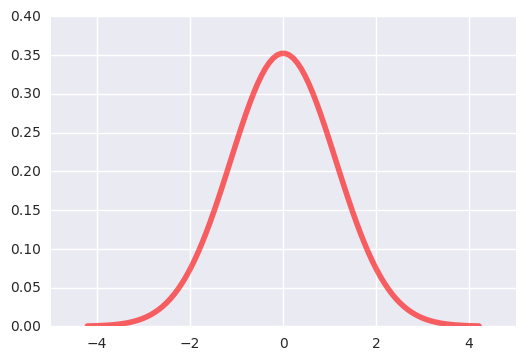

In [196]:
# Plot the distribution of the test Statistic
test_statistic.plot_pdf()

In [187]:
# Build your hypothesis test object
# You are only required to implement one tailed tests
H0 = 'mean(Group_A) - mean(Group_B) = 0'
H1 = 'mean(Group_A) - mean(Group_B) > 0'
hypothesis_test = ht.HypothesisTest(test_statistic, H0, H1, alpha=0.05)

In [189]:
# Output the p-value
hypothesis_test.p_value(test_data)

0.3409982692823248

In [190]:
# Output the critical value (value for which the probability is alpha)
# This is a one tailed test so this would be the point where 1 - cdf = alpha
hypothesis_test.critical_value()

1.8625947657958184

In [192]:
# Method for thesting if H0 should be rejected
hypothesis_test.reject_H0(test_data)

False

# Let's get to work!
### <font color='blue'>Exercise 1 – Hypothesis Testing Module</font>
Form groups of 3 students they will be called A, B and C:

## <font color='blue'>General Tasks:</font>
Discuss the general design of the Hypothesis Testing module.
What parameters do you need the Classes to have, what methods should each Class implement and how will you call them.
Once you have established this stucture you can go ahead and perform your specific tasks.

## <font color='blue'>Tasks for A:</font>
- Implement the Hypothesis Testing Module according to the provided specifications. You need to be able to performe all the describes tasks.

## <font color='blue'>Tasks for B:</font>
- Implement the tests for the Hypothesis Testing Module
(Hint: you should think about cases where you know the ground truth and you need to check if the result of your Hypothesis test is constist with the truth. In particular you can generate sample data for this task.)

## <font color='blue'>Tasks for B:</font>
- Create a User guide for the Hypothesis Testing Module. This should be similar to the example provided, but exaplained in a general way.